In [13]:
import torch
import networkx as nx
from node2vec import Node2Vec


import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
graph = nx.fast_gnp_random_graph(n=40, p=0.5)
graph = nx.lollipop_graph(m=25, n=15)

In [48]:
# nx.draw_networkx_labels(graph, pos=nx.spring_layout(graph))

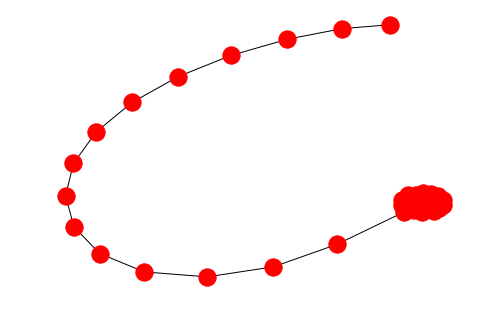

In [49]:
nx.draw(graph)
plt.show()

In [50]:
nx.adjacency_matrix(graph).todense()

matrix([[0, 1, 1, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 1, 0, 1],
        [0, 0, 0, ..., 0, 1, 0]], dtype=int64)

## Node2Vec

In [105]:
node2vec = Node2Vec(graph, dimensions=10, walk_length=8, num_walks=10, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

model.wv.cosine_similarities(model.wv.get_vector('39'), \
[model.wv.get_vector('36'),model.wv.get_vector('1'), model.wv.get_vector('12'), model.wv.get_vector('1')])


Computing transition probabilities: 100%|██████████| 40/40 [00:00<00:00, 357.83it/s]


array([0.66939795, 0.6640393 , 0.5531998 , 0.6640393 ], dtype=float32)

## GraRep

In [98]:
from scipy.sparse import lil_matrix
from scipy.sparse import csr_matrix
from scipy.linalg import norm

from scipy.sparse.linalg import svds 
import numpy as np
def get_representations(A,K,beta):
    #Extract list of similarity matrices to be factorized

    print('Computing representations')
    A_temp = []
    X_rep = []

    A_o = csr_matrix(A)
    A_prev = csr_matrix(A)
    A_temp.append(A_o.todense())
    for k in range(K-1):
        A_last = csr_matrix(A_prev.dot(A_o))
        A_temp.append(A_last.todense())
        A_prev = A_last

    k =1
    for A_k in A_temp:
        k+=1
        A_k = np.array(A_k)
        g = A_k.sum(axis=0)
        g = np.array(np.power(g*beta/float(len(g)),-1))
        B = np.log(A_k.dot(np.diag(np.reshape(g, [len(g)] ))).clip(min=1.0))
        X_rep.append( B )

    return X_rep

def get_embeddings(X_rep,N,dimension,K):
    #Factorize (SVD) and concatenate similarity matrices

    print('Extracting embeddings..')
    E = np.ndarray( (N,dimension) )
 
    width = dimension // K

    mod = dimension -  width*K 
    U,S,V = svds(X_rep[0], width + mod )
    E[:,:width+mod] = U @ np.power(np.diag(S), 0.5)

    for k in range(K-1):
        U,S,V = svds(X_rep[k+1], width + mod )   
        E[:, width*(k+1)+mod : width*(k+2)+mod] = U @ np.power(np.diag(S), 0.5)
    return E    


In [102]:
A = nx.adj_matrix(graph)
K = 10 # Number of transition steps
beta = 1.0
dimension = 10
X_rep = get_representations(A, K, beta )
    
E = get_embeddings(X_rep, A.get_shape()[0], dimension, K)
 

Computing representations
Extracting embeddings..


In [103]:
norm(E[0] - E[39]), norm(E[36] - E[39])

(2.2324129206130894, 0.007067156578671926)

In [104]:
E[36], E[39]

(array([ 7.66895525e-08,  1.76256349e-04, -1.45578751e-03,  2.06311649e-03,
        -7.37060092e-04, -3.68138445e-04,  4.55236583e-03,  4.75314515e-03,
        -7.55284107e-04,  7.73997429e-17]),
 array([ 1.72036273e-10,  9.99326607e-06, -2.02746885e-04,  1.18563352e-04,
        -2.67619381e-16,  1.21198756e-16, -2.15575656e-16,  3.67916122e-16,
        -9.63666380e-17,  1.16405415e-16]))

## Graph Convolution

In [115]:
import networkx as nx
import scipy.sparse as sp

def preprocess_features(features, sparse=False):
    """Row-normalize feature matrix and convert to tuple representation"""
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    # features = features/features.shape[1]
    if sparse:
        return sparse_to_tuple(features)
    return features


def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()


def preprocess_adj(adj, sparse=False):
    """
    Preprocessing of adjacency matrix for 
    simple GCN model and conversion to tuple representation.
    """
    # adj_normalized = normalize_adj(adj)
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    # adj_normalized = sp.coo_matrix(adj)
    if sparse:
        return sparse_to_tuple(adj_normalized)
    return adj_normalized

def sparse_to_tuple(sparse_mx):
    """Convert sparse matrix to tuple representation."""
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx

In [221]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module


class GraphConvolution(Module):
    def __init__(self, in_features, out_features, bias=False):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1) + self.weight.size(0))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'


class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid, bias=False)
        self.gc2 = GraphConvolution(nhid, nclass, bias=False)
        self.dropout = dropout
        
    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, p=0.1)
        x = self.gc2(x, adj)
        return x

In [222]:
_model = GCN(nfeat=40, nhid=15, nclass=5, dropout=True) 

A = nx.adjacency_matrix(graph).todense()
I = np.eye(graph.number_of_nodes())

output_torch = _model(torch.tensor(preprocess_features(I), dtype=torch.float), 
                      torch.tensor(preprocess_adj(A).todense(), dtype=torch.float))

Output feature for random weights:

In [223]:
output_torch.detach()

tensor([[-0.0087,  0.0063,  0.0036,  0.0009, -0.0007],
        [-0.0087,  0.0063,  0.0036,  0.0009, -0.0007],
        [-0.0087,  0.0063,  0.0036,  0.0009, -0.0007],
        [-0.0087,  0.0063,  0.0036,  0.0009, -0.0007],
        [-0.0087,  0.0063,  0.0036,  0.0009, -0.0007],
        [-0.0087,  0.0063,  0.0036,  0.0009, -0.0007],
        [-0.0087,  0.0063,  0.0036,  0.0009, -0.0007],
        [-0.0087,  0.0063,  0.0036,  0.0009, -0.0007],
        [-0.0087,  0.0063,  0.0036,  0.0009, -0.0007],
        [-0.0087,  0.0063,  0.0036,  0.0009, -0.0007],
        [-0.0087,  0.0063,  0.0036,  0.0009, -0.0007],
        [-0.0087,  0.0063,  0.0036,  0.0009, -0.0007],
        [-0.0087,  0.0063,  0.0036,  0.0009, -0.0007],
        [-0.0087,  0.0063,  0.0036,  0.0009, -0.0007],
        [-0.0087,  0.0063,  0.0036,  0.0009, -0.0007],
        [-0.0087,  0.0063,  0.0036,  0.0009, -0.0007],
        [-0.0087,  0.0063,  0.0036,  0.0009, -0.0007],
        [-0.0087,  0.0063,  0.0036,  0.0009, -0.0007],
        [-

In [216]:
gc_test1 = GraphConvolution(40, 15)
gc_test2 = GraphConvolution(15, 4)

_out_tt = gc_test1(torch.tensor(I,dtype=torch.float),\
        torch.tensor(preprocess_adj(A).todense(), dtype=torch.float))
_out_tt = gc_test2(_out_tt, torch.tensor(preprocess_adj(A).todense(), dtype=torch.float)).detach()

_out_tt

tensor([[-0.0058,  0.0079,  0.0066, -0.0107],
        [-0.0058,  0.0079,  0.0066, -0.0107],
        [-0.0058,  0.0079,  0.0066, -0.0107],
        [-0.0058,  0.0079,  0.0066, -0.0107],
        [-0.0058,  0.0079,  0.0066, -0.0107],
        [-0.0058,  0.0079,  0.0066, -0.0107],
        [-0.0058,  0.0079,  0.0066, -0.0107],
        [-0.0058,  0.0079,  0.0066, -0.0107],
        [-0.0058,  0.0079,  0.0066, -0.0107],
        [-0.0058,  0.0079,  0.0066, -0.0107],
        [-0.0058,  0.0079,  0.0066, -0.0107],
        [-0.0058,  0.0079,  0.0066, -0.0107],
        [-0.0058,  0.0079,  0.0066, -0.0107],
        [-0.0058,  0.0079,  0.0066, -0.0107],
        [-0.0058,  0.0079,  0.0066, -0.0107],
        [-0.0058,  0.0079,  0.0066, -0.0107],
        [-0.0058,  0.0079,  0.0066, -0.0107],
        [-0.0058,  0.0079,  0.0066, -0.0107],
        [-0.0058,  0.0079,  0.0066, -0.0107],
        [-0.0058,  0.0079,  0.0066, -0.0107],
        [-0.0058,  0.0079,  0.0066, -0.0107],
        [-0.0058,  0.0079,  0.0066